In [177]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import os
import sys
import seaborn as sns
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import inspect
path = "F:\shreeradha\cs726\cs726project\code\CS726-2024-OOD-Detection\Glow\checkpoints\glow_checkpoint_120.pt"
parent_dir = "F:\shreeradha\cs726\cs726project\code\CS726-2024-OOD-Detection"
data = "F:\shreeradha\cs726\cs726project\code\data"
sys.path.append(parent_dir)
from build_dataset import build_or_get_dataset, get_dataloader
from model import Glow
device = torch.device("cuda")
from config import get_config
config = get_config()


In [178]:
num_classes = 10
image_shape = (32, 32, 3)
model = Glow(image_shape,config['hidden_channels'],config['K'],config['L'],config['actnorm_scale'],
    config['flow_permutation'],config['flow_coupling'],config['LU_decomposed'],num_classes,config['learn_top'],config['y_condition'],
)
model.load_state_dict(torch.load(path)['model'])
model.set_actnorm_init()
model = model.to(device)
model = model.eval()

In [179]:
_, testset_in, classes = build_or_get_dataset('cifar10', data,True)
_, testset_out, _= build_or_get_dataset('svhn', data,True)

Files already downloaded and verified


Files already downloaded and verified
Using downloaded and verified file: F:\shreeradha\cs726\cs726project\code\data\train_32x32.mat
Using downloaded and verified file: F:\shreeradha\cs726\cs726project\code\data\test_32x32.mat


In [180]:
testloader_in = get_dataloader(testset_in, batch_size = 5, shuffle= True)
testloader_out = get_dataloader(testset_out, batch_size = 5, shuffle= True)

In [181]:
label_map = ["airplane", 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship',  'truck']

In [182]:
def show_images(images, labels, title, data):
    plt.figure(figsize=(10, 3))
    for i in range(min(len(images), 5)):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Convert from tensor to numpy array and transpose dimensions
        if data == 'cifar':
            plt.title(f"Label: {torch.argmax(labels[i])}, {label_map[torch.argmax(labels[i])]}")
        else : 
            plt.title(f"Label: {torch.argmax(labels[i])}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

In [183]:
dataiter_in = iter(testloader_in)
dataiter_out = iter(testloader_out)

In [184]:
concat = lambda x: np.concatenate(x, axis=0)
to_np = lambda x: x.data.cpu().numpy()
def get_ood_scores(images, target, T=1):

    with torch.no_grad():
        images = images.to(device)
        target = target.to(device)   
        z, nll, output = model(images, y_onehot=target) # output is class_logits assigned by gen model
        smax = to_np(F.softmax(output, dim=1))
        ener =-to_np((T*torch.logsumexp(output /T, dim=1)))
        msp=np.max(smax, axis=1)
        preds = np.argmax(smax, axis=1)
    return msp , ener, nll, z, preds

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Images and labels from testloader_in:


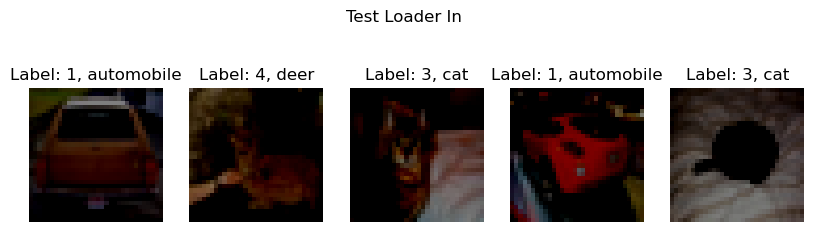

In [185]:
# Print first 5 images and their labels from testloader_in
images_in, labels_in = next(dataiter_in)
print("Images and labels from testloader_in:")
show_images(images_in, labels_in, "Test Loader In", 'cifar')

In [186]:
msp , energy, nll, _ , pred= get_ood_scores(images_in, labels_in)

In [187]:
print("MSP", list(msp))
print("Energy", list(energy))
print("NLL", list(nll))
print("prediction", list(pred))

MSP [0.8130567, 0.96685725, 0.7251801, 0.95577633, 0.96180737]
Energy [-8.036183, -6.3017993, -9.426325, -10.036131, -10.717091]
NLL [tensor(3.6104, device='cuda:0'), tensor(3.4329, device='cuda:0'), tensor(3.8282, device='cuda:0'), tensor(4.7691, device='cuda:0'), tensor(3.3917, device='cuda:0')]
prediction [1, 4, 5, 1, 2]


0"airplane", 1'automobile', 2'bird', 3'cat', 4'deer', 5'dog', 6'frog', 7'horse', 8'ship',  9'truck'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Images and labels from testloader_out:


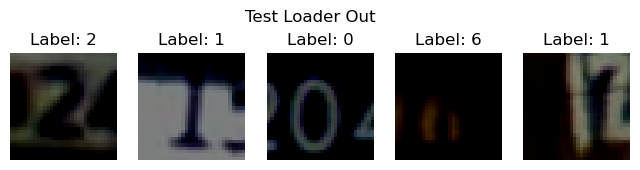

In [120]:

# Print first 5 images and their labels from testloader_out
images_out, labels_out = next(dataiter_out)
print("Images and labels from testloader_out:")
show_images(images_out, labels_out, "Test Loader Out", 'svhn')

In [172]:
msp , energy, nll, _ , pred= get_ood_scores(images_out, labels_out)

In [174]:
print("MSP", list(msp))
print("Energy", list(energy))
print("NLL", list(nll))

MSP [0.8883491, 0.51837945, 0.9919003, 0.8048418, 0.8467822]
Energy [-9.8061, -8.4480505, -11.040635, -7.794653, -12.593739]
NLL [tensor(2.6175, device='cuda:0'), tensor(2.4581, device='cuda:0'), tensor(3.3017, device='cuda:0'), tensor(2.2928, device='cuda:0'), tensor(2.8058, device='cuda:0')]
